# **Deliverable 2: X-ray Imaging and Computed Tomography (CT)**

---

## Overview

This deliverable covers key concepts from **Lectures 13–18** (Weeks 6–7) of the course. You will explore:

- X-ray tube design and production
- Projection radiography geometry, contrast, and scatter reduction
- Digital X-ray detectors and image formation
- CT acquisition, reconstruction, image quality, and dose metrics
- Protocol design and optimization for clinical goals

You will engage with the material through conceptual questions, coding exercises, error analysis, and a design challenge. By the end of this deliverable, you will be able to analyze and simulate X-ray and CT imaging systems, interpret image quality trade-offs, optimize protocols, and apply quantitative reasoning to real-world clinical scenarios.

---

## Part 1: X-ray Production and Spectrum



### Key Concepts

- **X-ray Tube Physics:** X-rays are produced when high-speed electrons strike a metal target (anode), resulting in rapid deceleration (bremsstrahlung) and ejection of inner-shell electrons (characteristic X-rays). The output spectrum is a combination of continuous (bremsstrahlung) and discrete (characteristic) peaks.
- **Tube Voltage (kVp):** Sets the maximum photon energy; higher kVp increases beam penetration but reduces contrast.
- **Tube Current (mA):** Controls the number of electrons (and thus photons) produced per second; affects image brightness and patient dose.
- **Filtration:** Removes low-energy photons (which contribute to dose but not image quality), resulting in a "harder" (higher average energy) spectrum. The filtered spectrum $I(E)$ is zero for $E < E_{filter}$.
- **Anode Material:** Determines the energy of characteristic peaks (e.g., tungsten anode: 59 and 67 keV).


### 1.1 X-ray Tube Design Scenario

You are tasked with designing an X-ray tube for a pediatric chest radiography system. The goal is to minimize patient dose while maintaining diagnostic image quality.


### **Question 1**

- a)  Explain the roles of tube voltage (kVp) and tube current (mA) in shaping the X-ray spectrum and affecting patient dose.

    Tube voltage (kVp) determines the nature of the spectrum, including which (if any) characteristic peaks occur as well as the overall energy of the produced X-rays. 
    Most of the energy content in a beam of X-rays comes from bremsstrahlung at an energy approximately one-third of the tube voltage; in addition, tube voltages above the electron shell binding energies allow characteristic X-rays to be produced. 
    Higher-energy photons have smaller photoelectric cross-sections and so will petetrate better (helping reduce noise), but also have larger Compton cross-sections and so will reduce the image contrast.
    Different tube voltages can also be used for various dual-energy types of imaging; adjusting the photon energies to be just above and just below a K-edge in the patient or contrast agent can allow for isolation of different features.

    Tube current (mA), meanwhile, affects the number of photons produced. In general, this relationship is proportional, meaning that higher tube currents result in higher dosages and vice versa. Since the SNR of a quantum-limited imaging system is proportional to the square root of the number of detected photons, increasing tube current will allow for brighter and less noisy images at the cost of this reduced dose.

- b) Describe how filtration and the choice of anode material influence the X-ray spectrum and image quality.

    Filtration, or 'hardening', of the beam before it reaches the patient allows for low-energy photons which contribute to dose but are highly likely to be absorbed (due to a large cross-section) before reaching the detector regardless of their path (i.e. they do not contribute to the image contrast) to be removed. This produces a low-end cutoff of the X-ray spectrum. It very slightly degrades image quality (requiring a small increase in tube current to compensate), but reduces the dose received by the patient even considering this required increase in tube current.

- c) Propose a set of tube parameters (kVp, mA, filtration) for pediatric imaging and justify your choices based on physical principles.

    Children are more susceptible to radiation dose than adults, and so dosage considerations are especially important. For chest radiography in particular, the air in the lungs has significantly less attenuation than the mediastinum and bone surrounding it, which means that the photoelectric effect will produce more image contrast, and thus that we can use higher tube voltage and lower tube current to reduce the dose. For the same reason, we should use a filter to harden the beam and further reduce the dose.

    







### **Coding Exercise 1**

1. Implement a function `simulate_xray_spectrum(kvp, e_filter)` that returns the energy (keV) and relative intensity arrays.
2. Plot the spectrum for kVp = 80, 100, 120 keV and E_filter = 30 keV.

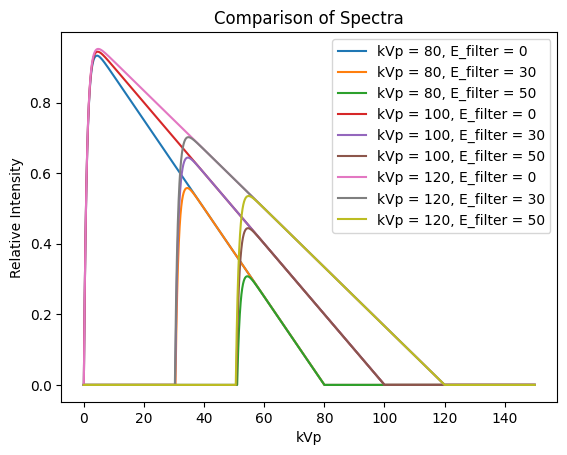

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_xray_spectrum(kvp, e_filter):
    energies = np.arange(0, 150, 0.01)
    
    # Simple model: roughly linear (ideal) bremsstrahlung spectrum, hard cutoff
    relative_intensities = (kvp - energies) / kvp 
    for i, intensity in enumerate(relative_intensities):
        if energies[i] <= e_filter:
            relative_intensities[i] = 0
        elif intensity < 0:
            relative_intensities[i] = 0
        else:
            # add some non-linearity; bremsstrahlung peak should be at kvp/3 (TODO)
            relative_intensities[i] = relative_intensities[i] - np.exp(-energies[i] + e_filter)
            if relative_intensities[i] < 0:
                relative_intensities[i] = 0
    
    return relative_intensities


# TODO: Simulate the X-ray spectrum
kvps = [80, 100, 120]
e_filters = [0, 30, 50]
legend = []

# TODO: Plot the spectrum for different kVp and E_filter values
for energy in kvps:
    for filter in e_filters:
        plt.plot(np.arange(0, 150, 0.01), simulate_xray_spectrum(energy, filter))
        legend.append(f"kVp = {energy}, E_filter = {filter}")
plt.legend(legend)
plt.xlabel("kVp"); plt.ylabel("Relative Intensity"); plt.title("Comparison of Spectra")
plt.show()

# TODO: Analyze and discuss the results
# ...

---

## Part 2: CT Simulation, Error Analysis & Design

### Key Concepts

- Shepp-Logan Phantom: A digital test object for CT simulation.
- Sinogram: 2D plot of projection data as a function of angle and position.
- Image Reconstruction: Filtered backprojection and iterative methods.
- Error Analysis: Identifying and quantifying sources of error/artifacts in CT reconstruction.
- Design & Optimization: Creating and optimizing CT protocols for specific clinical goals.


### 2.1 Shepp-Logan Phantom and Sinogram

### **Coding Exercise 2**

- a) Generate a Shepp-Logan digital phantom in Python (use `skimage.data.shepp_logan_phantom` or custom code).
- b) Simulate CT projections (sinogram) of the phantom using the Radon transform.
- c) Reconstruct the image from the sinogram using filtered backprojection.


In [5]:
# TODO: Generate a Shepp-Logan phantom
# %pip install scikit-image
from skimage.data import shepp_logan_phantom
phantom = shepp_logan_phantom()

# TODO: Simulate CT projections (sinogram) using the Radon transform
# ...

# TODO: Reconstruct the image from the sinogram
# ...

# TODO: Visualize the phantom, sinogram, and reconstruction
# ...


### 2.2 Error Analysis


### **Question 2**

- a) Identify and describe at least one source of error or artifact in your reconstructed image (e.g., limited projections, noise, motion, beam hardening).
- b) Quantify the impact of one error (e.g., measure reconstruction error as projections are reduced or noise is increased).
- c) Propose and implement a method to mitigate one artifact or error, and evaluate its effectiveness.


### **Coding Exercise 3**

Implement your method to mitigate an artifact or error and evaluate its effectiveness.

In [ ]:
# TODO: Implement a method to mitigate the artifact or error
# ...

# TODO: Evaluate and discuss the effectiveness of your method
# ...

### 2.3 CT Protocol Design & Optimization


### **Question 3**

- a) Choose a clinical goal (e.g., maximize nodule detectability, minimize dose).
- b) Optimize acquisition parameters (number of projections, rotation angles, detector size, noise level) to achieve your goal.
- c) Justify your design choices based on physical principles and clinical needs.
- d) Reflect on the trade-offs and limitations of your design.


---

## Part 3: Projection Radiography & Image Quality



### Key Concepts

- **Scatter:** Primarily due to Compton interactions; scattered photons degrade image contrast by adding unwanted background signal. Scatter increases with patient thickness and field size. (See Lecture 14)
- **Geometric Unsharpness ($U_g$):** Caused by the finite size of the X-ray source.
- **Contrast Degradation:** The scatter-to-primary ratio (SPR) quantifies the amount of scatter relative to primary photons. Higher SPR means lower contrast. Contrast degradation factor:

$$C_{degraded} = \frac{C_{ideal}}{1 + SPR}$$
- **Scatter Reduction:** Use of grids, air gaps, or collimation can reduce scatter but may increase dose or reduce signal.


### 3.1 Scatter and Contrast


### **Questions 4**

- a) Explain the physical origin of scatter in projection radiography and its impact on image contrast.
- b) Describe two methods to reduce scatter and discuss their trade-offs.
- c) Calculate the contrast degradation factor if the scatter-to-primary ratio (SPR) is 1.5. What percent of the original contrast remains?


### **Coding Exercise 4**

1. Implement `geometric_unsharpness(f, a, b)`.
2. Plot $U_g$ as a function of $b$ for $f=1$ mm, $a=100$ cm, and $b$ from 0 to 20 cm.

In [ ]:
# TODO: Implement geometric_unsharpness(f, a, b)
# def geometric_unsharpness(f, a, b):
#     ...

# TODO: Plot U_g as a function of b
# ...

### 3.2 Quantitative Comparison of Scatter Reduction Techniques


### **Questions 5**

- a) For each technique, calculate the percent contrast improvement using the contrast degradation formula.
- b) Summarize your findings: Which technique is most effective? What are the trade-offs (e.g., dose, practicality, image artifacts)?

### 3.3 Simulating Scatter Effects and Grid Optimization

### **Coding Exercise 5**

In this exercise, you will simulate the effect of scatter on a simple X-ray image and explore how grid design can optimize image contrast.

**Scenario:**
You are given a 1D 'image' (e.g., a step function representing an object) and must model the effect of scatter as an additive background proportional to the primary signal. You will then simulate the use of an anti-scatter grid with variable grid ratio to reduce scatter, and determine the optimal grid ratio for maximizing contrast while considering signal loss.

**Tasks:**
1. Simulate the effect of scatter on a simple 1D object (e.g., a step function) by adding a scatter component proportional to the primary signal using the fixed SPR value.
2. Model the impact of an anti-scatter grid: for each grid ratio $G$, reduce scatter by $1/(1+G)$ and primary signal by $T_p$ (e.g., $T_p = 1 - 0.02 \times G$).
3. Plot image contrast as a function of grid ratio for the fixed SPR, and identify the grid ratio that maximizes contrast. 

**Hints:**
- Use matplotlib for plotting.
- You may assume a fixed SPR value (e.g., SPR = 1.5).
- You may define contrast as $(I_{max} - I_{min})/(I_{max} + I_{min})$ for the detected signal.
- You may use a simple linear model for $T_p(G)$, e.g., $T_p = 1 - 0.02 	imes G$ (for $G$ from 0 to 12).

In [ ]:
# TODO: Simulate scatter and grid optimization for a 1D image
# ...

# TODO: Plot and analyze the effect of grid ratio on contrast
# ...

# TODO: Discuss your findings and trade-offs
# ...

---

## Part 4: X-ray Detectors & Quantum Efficiency



### Key Concepts

- **Quantum Efficiency (QE):** The fraction of incident X-ray photons detected and converted to signal. Higher QE improves SNR and allows for lower patient dose.

$$QE = \frac{\text{Detected photons}}{\text{Incident photons}}$$
- **Detective Quantum Efficiency (DQE):** Describes how well a detector preserves SNR across spatial frequencies.

$$DQE(f) = \frac{(SNR_{out}(f))^2}{(SNR_{in}(f))^2}$$
- **Readout Noise:** Electronic noise added during signal readout; becomes significant at low doses or for low-signal regions.
- **Detector Types:** Indirect (scintillator + photodiode) and direct (photoconductor) detectors have different QE and noise characteristics.


### 4.1 Detector Selection Scenario

### **Questions 6**

You are comparing two digital X-ray detectors for a trauma imaging suite:

   1.  Detector A: High quantum efficiency (QE), moderate readout noise
   2. Detector B: Lower QE, but very low readout noise

- a) Define quantum efficiency and explain its importance for image quality and dose.
- b) Discuss the trade-offs between quantum efficiency and readout noise for low-dose imaging.
- c) Which detector would you recommend for pediatric trauma imaging and why?


### **Coding Exercise 6**

1. Modify the code to add a third detector (Detector C) with your own parameters for SNR_out_C.
2. Plot and compare the DQE for all three detectors.
3. Briefly discuss how your changes affect the DQE curves.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_dqe(snr_in, snr_out):
    return (snr_out ** 2) / (snr_in ** 2)

# Example data for two detectors
spatial_freq = np.linspace(0, 5, 50)  # cycles/mm
snr_in = 100 * np.exp(-0.2 * spatial_freq)
snr_out_A = 80 * np.exp(-0.4 * spatial_freq)  # High QE, moderate noise
snr_out_B = 60 * np.exp(-0.25 * spatial_freq)  # Lower QE, low noise

dqe_A = compute_dqe(snr_in, snr_out_A)
dqe_B = compute_dqe(snr_in, snr_out_B)

plt.figure(figsize=(7,4))
plt.plot(spatial_freq, dqe_A, label='Detector A (High QE)')
plt.plot(spatial_freq, dqe_B, label='Detector B (Low Noise)')
plt.xlabel('Spatial Frequency (cycles/mm)')
plt.ylabel('DQE')
plt.title('Detective Quantum Efficiency vs. Spatial Frequency')
plt.legend()
plt.grid(True)
plt.show()

# TODO: Briefly discuss how your changes affect the DQE curves.

### **Coding Exercise 7**

1. Display the original image.
2. Apply contrast enhancement.
3. Apply brightness adjustment.
4. Display the adjusted images side-by-side.
5. Discuss how these changes affect image quality and visibility of features.

In [ ]:
#USE IMAGE 'Xray_Chest.png'

# TODO: Apply contrast enhancement
# ...

# TODO: Apply brightness adjustment
# ...

# TODO: Display the original and adjusted images
# ...

# TODO: Discuss the effects below

---

## Part 5: Computed Tomography (CT) Principles & Image Reconstruction



### Key Concepts

- **Hounsfield Units (HU):** Quantifies tissue attenuation relative to water.

$$HU = 1000 \cdot \frac{\mu_{tissue} - \mu_{water}}{\mu_{water}}$$
- **CT Projections:** Each projection is a line integral of attenuation coefficients along a path through the object:

$$P(\theta, t) = \int \mu(x, y) ds$$
- **Sinogram:** A 2D plot of projection data as a function of angle and position; each point in the object traces a sinusoidal path in the sinogram.
- **Image Reconstruction:** Filtered backprojection and iterative methods reconstruct the 2D image from projections.


### 5.1 Hounsfield Units and Tissue Contrast


### **Questions 7**

- a)  Define the Hounsfield unit and explain how it is calculated from measured attenuation coefficients.
- b) Calculate the HU for a tissue with:

$$
\mu_{\text{tissue}} = 0.22\ \text{cm}^{-1}, \quad
\mu_{\text{water}} = 0.20\ \text{cm}^{-1}, \quad
\mu_{\text{air}} = 0.0002\ \text{cm}^{-1}
$$

Show your calculation step by step.

- c) Discuss the clinical significance of HU values in CT imaging.


### **Coding Exercise 8**

1. Create a 2D numpy array representing a phantom with a circular region of higher attenuation.
2. Simulate the projection (sum of attenuation) at a given angle.
3. Plot the phantom and its projection profile.

In [ ]:
# TODO: Create a 2D numpy array phantom with a circular region
# ...

# TODO: Simulate the projection (sum of attenuation) at a given angle
# ...

# TODO: Plot the phantom and its projection profile
# ...

---

## Part 6: CT Image Quality, Artifacts, and Dose Optimization



### Key Concepts

- **Streak Artifacts:** Appear as bright/dark lines, often caused by high-attenuation objects (metal), beam hardening (lower energy photons absorbed more), or photon starvation (very low signal).
- **Noise:** In CT, noise is primarily quantum (photon) noise and is inversely proportional to the square root of dose:

$$\sigma = \frac{K}{\sqrt{D}}$$
- **Dose Optimization:** The goal is to minimize patient dose while maintaining diagnostic image quality. Techniques include automatic exposure control and iterative reconstruction.


### 6.1 CT Streak Artifact Analysis

### **Questions 8**

- a) Carefully examine the artifact in the image. Describe the physical and mathematical causes of streak artifacts in CT (reference concepts such as beam hardening, photon starvation, and reconstruction errors).
- b) Propose and explain at least two algorithmic or acquisition-based strategies to reduce or mitigate streak artifacts in clinical CT.


### **Coding Exercise 9**

1. Write a function `ct_noise_vs_dose(D, K)`.
2. Plot image noise as a function of dose for $K=10$ and $D$ from 1 to 100 (arbitrary units).

In [ ]:
# USE IMAGE 'Brain_CT.png'

# TODO: Write a function ct_noise_vs_dose(D, K)
# def ct_noise_vs_dose(D, K):
#     ...

# TODO: Plot image noise as a function of dose
# ...

# TODO: Analyze and discuss the results
# ...

---

## Part 7: Quantitative Analysis of CT Image Quality

### Key Concepts

- **SNR (Signal-to-Noise Ratio):**

$$\mathrm{SNR} = \frac{\mu_{signal}}{\sigma_{noise}}$$
- **RMSE (Root Mean Square Error):** Measures the average difference between two images:

$$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (I_i - I_{ref,i})^2}$$
- **Filtering:** Denoising filters (Gaussian, median, bilateral) can reduce noise but may blur edges or reduce detail.


### 7.1 SNR and RMSE Analysis


### **Coding Exercise 10**

1. Apply a denoising or edge-preserving filter of your choice (e.g., Gaussian, median, or bilateral filter).
2. Compute and compare the following metrics before and after filtering:
   - Signal-to-Noise Ratio (SNR)
   - Root Mean Square Error (RMSE)
   (You may use the original image as reference for RMSE, or compare to a region of interest.)
3. Discuss what these metrics reveal about image quality and the impact of filtering.

In [ ]:
# USE IMAGE 'Brain_CT.png'

# TODO: Apply a filter to img (e.g., Gaussian, median, etc.)
# filtered_img = ...

# TODO: Compute SNR and RMSE before and after filtering
# snr_before = ...
# snr_after = ...
# rmse = ...

# TODO: Visualize the original and filtered images
# ...

---

## **<u>Submission Requirements</u>**

**You must submit TWO files to D2L:**

1. **Jupyter Notebook** (`.ipynb`): Your completed notebook with all code, outputs, and written analysis. All cells must be executed in order.

2. **PDF Export** (`.pdf`): Export your notebook to PDF (File → Export as PDF, or print to PDF). Verify all figures and equations render correctly.

**Important:** All answers must be completed directly in this Jupyter notebook.

**File naming convention:** `LastName_FirstName_Deliverable2.ipynb` and `.pdf`

**Due:** Monday, March 2, 2026 at 11:59 PM

---

## Submission Summary

| Section | Questions/Analysis Due |
|---------|------------------------|
| **Part 1: X-ray Production & Spectrum** | Q1 (a,b,c), Coding Exercise 1 |
| **Part 2: CT Simulation, Error Analysis & Design** | Coding Exercise 2, Q2 (a,b,c), Coding Exercise 3, Q3 (a,b,c,d)  |
| **Part 3: Projection Radiography & Image Quality** | Q4 (a,b,c), Coding Exercise 4, Q5 (a,b), Coding Exercise 5 |
| **Part 4: X-ray Detectors & Quantum Efficiency** | Q6 (a,b,c), Coding Exercise 6, Coding Exercise 7|
| **Part 5: CT Principles & Image Reconstruction** | Q7 (a,b,c), Coding Exercise 8|
| **Part 6: CT Image Quality, Artifacts & Dose Optimization** | Q8 (a,b), Coding Exercise 9 |
| **Part 7: Quantitative Analysis of CT Image Quality** | Coding Exercise 10 |
